In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import scanpy as sc
sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=180, dpi_save=300, 
                              frameon=False, figsize=(4, 4), 
                              fontsize=8, facecolor='white')

In [2]:
sequencing_data_folder = r'\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\Sequencing_data\GSE223896'
library_folder = r'\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\Brain_MS_immune'


In [3]:
# Load raw WT
# Input files
sequencing_data_folder = r'\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\Sequencing_data\GSE223896'
wt_sample_name = 'WT_CNS_1_GEX'
for _fl in os.listdir(sequencing_data_folder):
    if wt_sample_name in _fl: # select sample
        if 'matrix.mtx' in _fl: 
            wt_mtx_file = os.path.join(sequencing_data_folder, _fl) 
        elif 'barcodes.tsv' in _fl:
            wt_barcode_file = os.path.join(sequencing_data_folder, _fl) 
        elif 'features.tsv' in _fl:
            wt_features_file = os.path.join(sequencing_data_folder, _fl) 
wt_adata_raw = sc.read_mtx(wt_mtx_file)
wt_adata_raw = wt_adata_raw.transpose() # The matrix has to be transposed because the genes and cells are fipped
# Load gene names
features = pd.read_csv(wt_features_file, sep='\t', header=None)
wt_adata_raw.var['gene_ids'] = list(features[0])
wt_adata_raw.var['gene_symbols'] = list(features[1])
wt_adata_raw.var = wt_adata_raw.var.set_index('gene_symbols')
wt_adata_raw.var_names_make_unique()
# Load cell IDs (barcodes)
barcodes = pd.read_csv(wt_barcode_file, sep=',', header=None, names=['barcode'])
new_barcodes = pd.DataFrame([f"WT_CNS_{_n.split('-')[1]}_{_n.split('-')[0]}" for _n in barcodes['barcode']],
                            columns=['barcode'])
wt_adata_raw.obs = new_barcodes.set_index('barcode')
wt_adata_raw.obs['treatment'] = 'WT'

In [4]:
# Load raw KO
# Input files
sequencing_data_folder = r'\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\Sequencing_data\GSE223896'
ko_sample_name = 'KO_CNS_1_GEX'
for _fl in os.listdir(sequencing_data_folder):
    if ko_sample_name in _fl: # select sample
        if 'matrix.mtx' in _fl: 
            ko_mtx_file = os.path.join(sequencing_data_folder, _fl) 
        elif 'barcodes.tsv' in _fl:
            ko_barcode_file = os.path.join(sequencing_data_folder, _fl) 
        elif 'features.tsv' in _fl:
            ko_features_file = os.path.join(sequencing_data_folder, _fl) 
ko_adata_raw = sc.read_mtx(ko_mtx_file)
ko_adata_raw = ko_adata_raw.transpose() # The matrix has to be transposed because the genes and cells are fipped
# Load gene names
features = pd.read_csv(ko_features_file, sep='\t', header=None)
ko_adata_raw.var['gene_ids'] = list(features[0])
ko_adata_raw.var['gene_symbols'] = list(features[1])
ko_adata_raw.var = ko_adata_raw.var.set_index('gene_symbols')
ko_adata_raw.var_names_make_unique()
# Load cell IDs (barcodes)
barcodes = pd.read_csv(ko_barcode_file, sep=',', header=None, names=['barcode'])
new_barcodes = pd.DataFrame([f"KO_CNS_{_n.split('-')[1]}_{_n.split('-')[0]}" for _n in barcodes['barcode']],
                            columns=['barcode'])
ko_adata_raw.obs = new_barcodes.set_index('barcode')
ko_adata_raw.obs['treatment'] = 'KO'

In [5]:
import anndata
# merge
merged_raw_adata = anndata.concat([wt_adata_raw,ko_adata_raw])
# QC
sc.pp.calculate_qc_metrics(merged_raw_adata, percent_top=None, log1p=False, inplace=True)

In [6]:
merged_raw_adata

AnnData object with n_obs × n_vars = 4970 × 32285
    obs: 'treatment', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## Load processed h5ad data

In [137]:
# load adata
nt_adata = sc.read_h5ad(os.path.join(library_folder, 'eae_cns_nT.h5ad'))

C:\Users\puzheng\.conda\envs\postanalysis\lib\site-packages\anndata\compat\__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


C:\Users\puzheng\.conda\envs\postanalysis\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


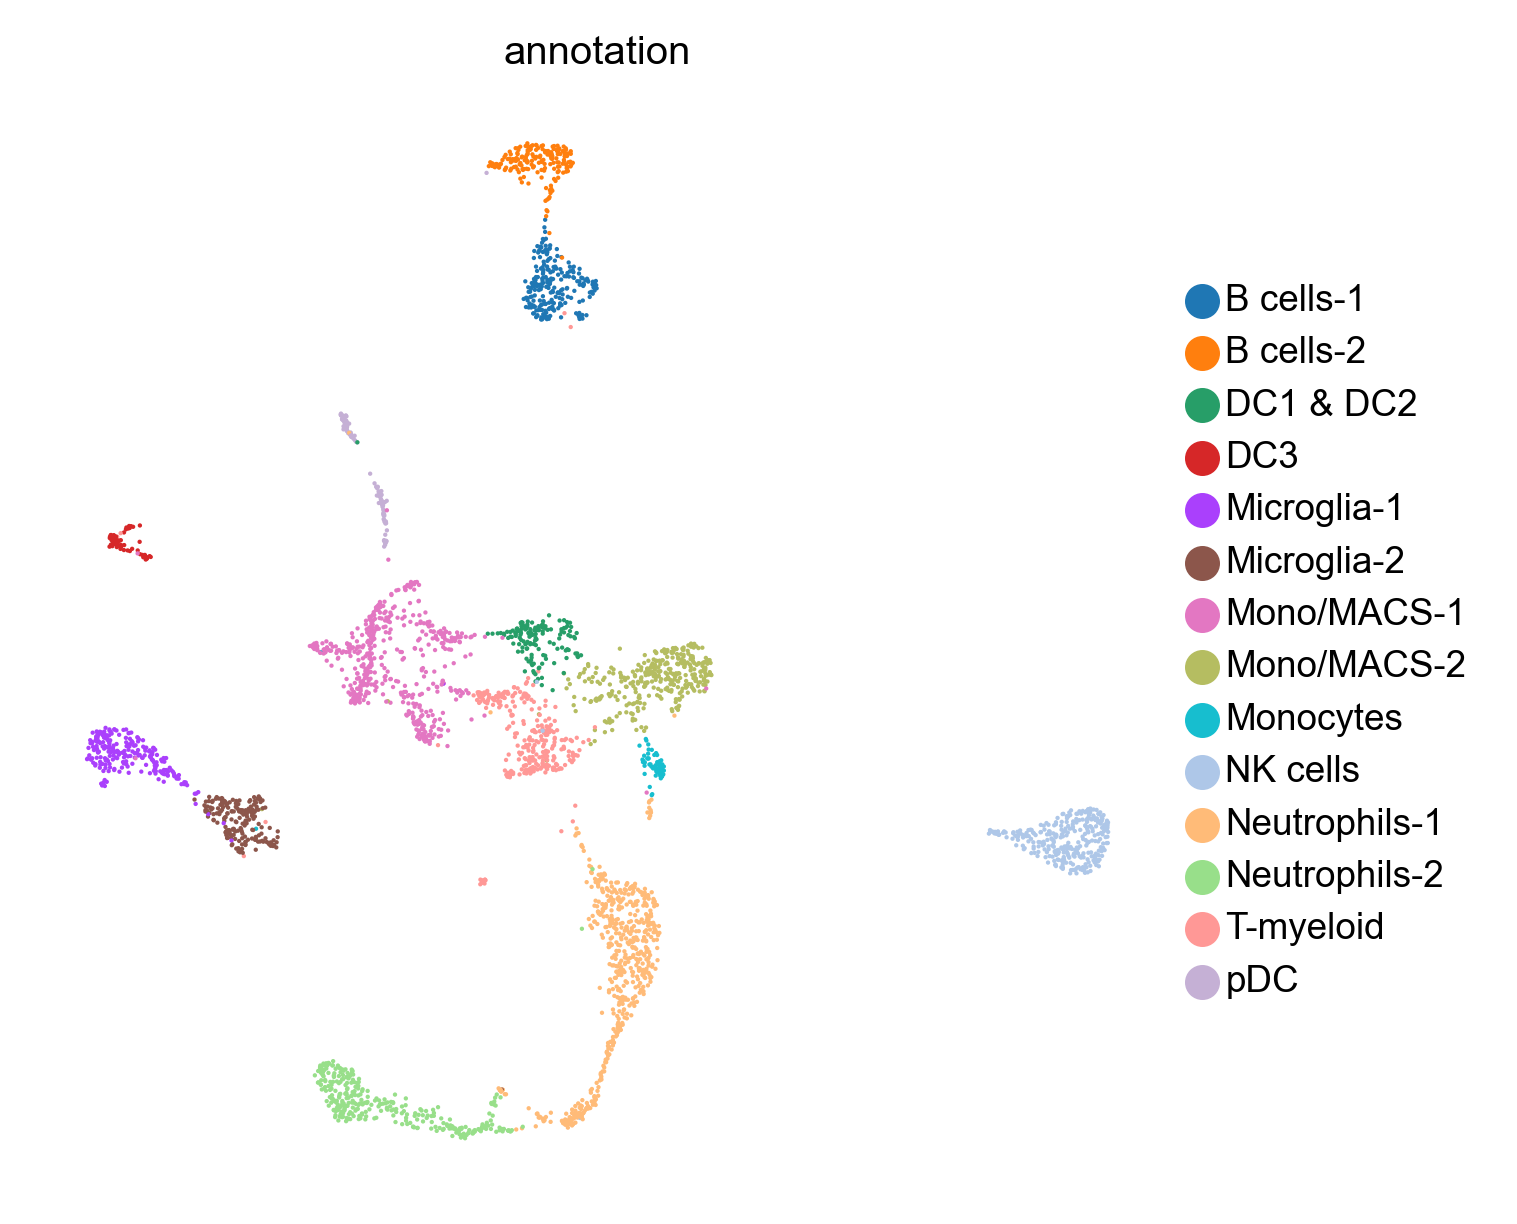

In [138]:
nt_umap = sc.pl.umap(nt_adata, color='annotation', s=3)

In [151]:
# match barcodes
update_obs_dict = {'annotation':[], 'seurat_clusters_new':[]}
for _idx, _row in merged_raw_adata.obs.iterrows():
    #print(_idx)
    if _idx in nt_adata.obs.index:
        update_obs_dict['annotation'].append(nt_adata.obs.loc[_idx, 'annotation'])
        update_obs_dict['seurat_clusters_new'].append(nt_adata.obs.loc[_idx, 'seurat_clusters_new'])
    else:
        update_obs_dict['annotation'].append('')
        update_obs_dict['seurat_clusters_new'].append(-1)
# update;
for _k, _v in update_obs_dict.items():
    merged_raw_adata.obs[_k] = _v

## save

In [161]:
# save
merged_raw_save_filename = os.path.join(os.path.join(library_folder, 'merged_raw.h5ad'))

overwrite = True

if not os.path.exists(merged_raw_save_filename) or overwrite:
    print(f"save adata into file: {merged_raw_save_filename}")
    merged_raw_adata.write(merged_raw_save_filename)
else:
    print(f"savefile: {merged_raw_save_filename} already exists")

save adata into file: \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\Brain_MS_immune\merged_raw.h5ad


In [167]:
# filter

filtered_raw_adata = merged_raw_adata[filtered_raw_adata.obs['annotation'] != '', 
                                      merged_raw_adata.var['n_cells_by_counts'] > 0]

In [257]:
# Calculate gene expression levels in the most highly expressed cell types
cluster_labels = np.unique(filtered_raw_adata.obs['annotation'])

gene_max_mean_cluster_counts = np.zeros(filtered_raw_adata.var.shape[0])

for cl in cluster_labels:
    gene_mean_cluster_counts = np.array(np.mean(filtered_raw_adata.X[filtered_raw_adata.obs['annotation'] == cl], axis=0)).flatten()
    gene_max_mean_cluster_counts = np.maximum(gene_max_mean_cluster_counts, gene_mean_cluster_counts)

filtered_raw_adata.var['max_mean_cluster_count'] = gene_max_mean_cluster_counts

### save

In [258]:
filtered_raw_save_filename = os.path.join(os.path.join(library_folder, 'filtered_raw.h5ad'))

overwrite = True

if not os.path.exists(filtered_raw_save_filename) or overwrite:
    print(f"save adata into file: {filtered_raw_save_filename}")
    filtered_raw_adata.write(filtered_raw_save_filename)
else:
    print(f"savefile: {filtered_raw_save_filename} already exists")

save adata into file: \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\Brain_MS_immune\filtered_raw.h5ad


### load and start from here:

In [247]:
## de-novo umap for filtered_data
filtered_raw_adata = sc.read_h5ad(filtered_raw_save_filename)

# Load manual selected genes

In [343]:
print(library_folder)

\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\Brain_MS_immune


In [344]:
selected_gene_filename = os.path.join(library_folder,
                                     'Merfish_library_EAE.xlsx')
selected_gene_df = pd.read_excel(selected_gene_filename, index_col=None)
# cleanup
type_2_genes = {_t:[_g for _g in selected_gene_df[_t].values if isinstance(_g, str)]
                for _t in selected_gene_df.columns}
#type_2_genes = 

In [345]:
selected_gene_list = []
for _type, _genes in type_2_genes.items():
    selected_gene_list += _genes

In [346]:
for _gene in selected_gene_list:
    if _gene not in merged_raw_adata.var.index:
        print(_gene)

## Umap for original data

In [254]:
# Preprocess
filtered_adata = filtered_raw_adata.copy()
# Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell
sc.pp.normalize_total(filtered_adata, target_sum=1e3)
# Logarithmize the data
sc.pp.log1p(filtered_adata)
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(filtered_adata, max_value=10)

C:\Users\puzheng\.conda\envs\postanalysis\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


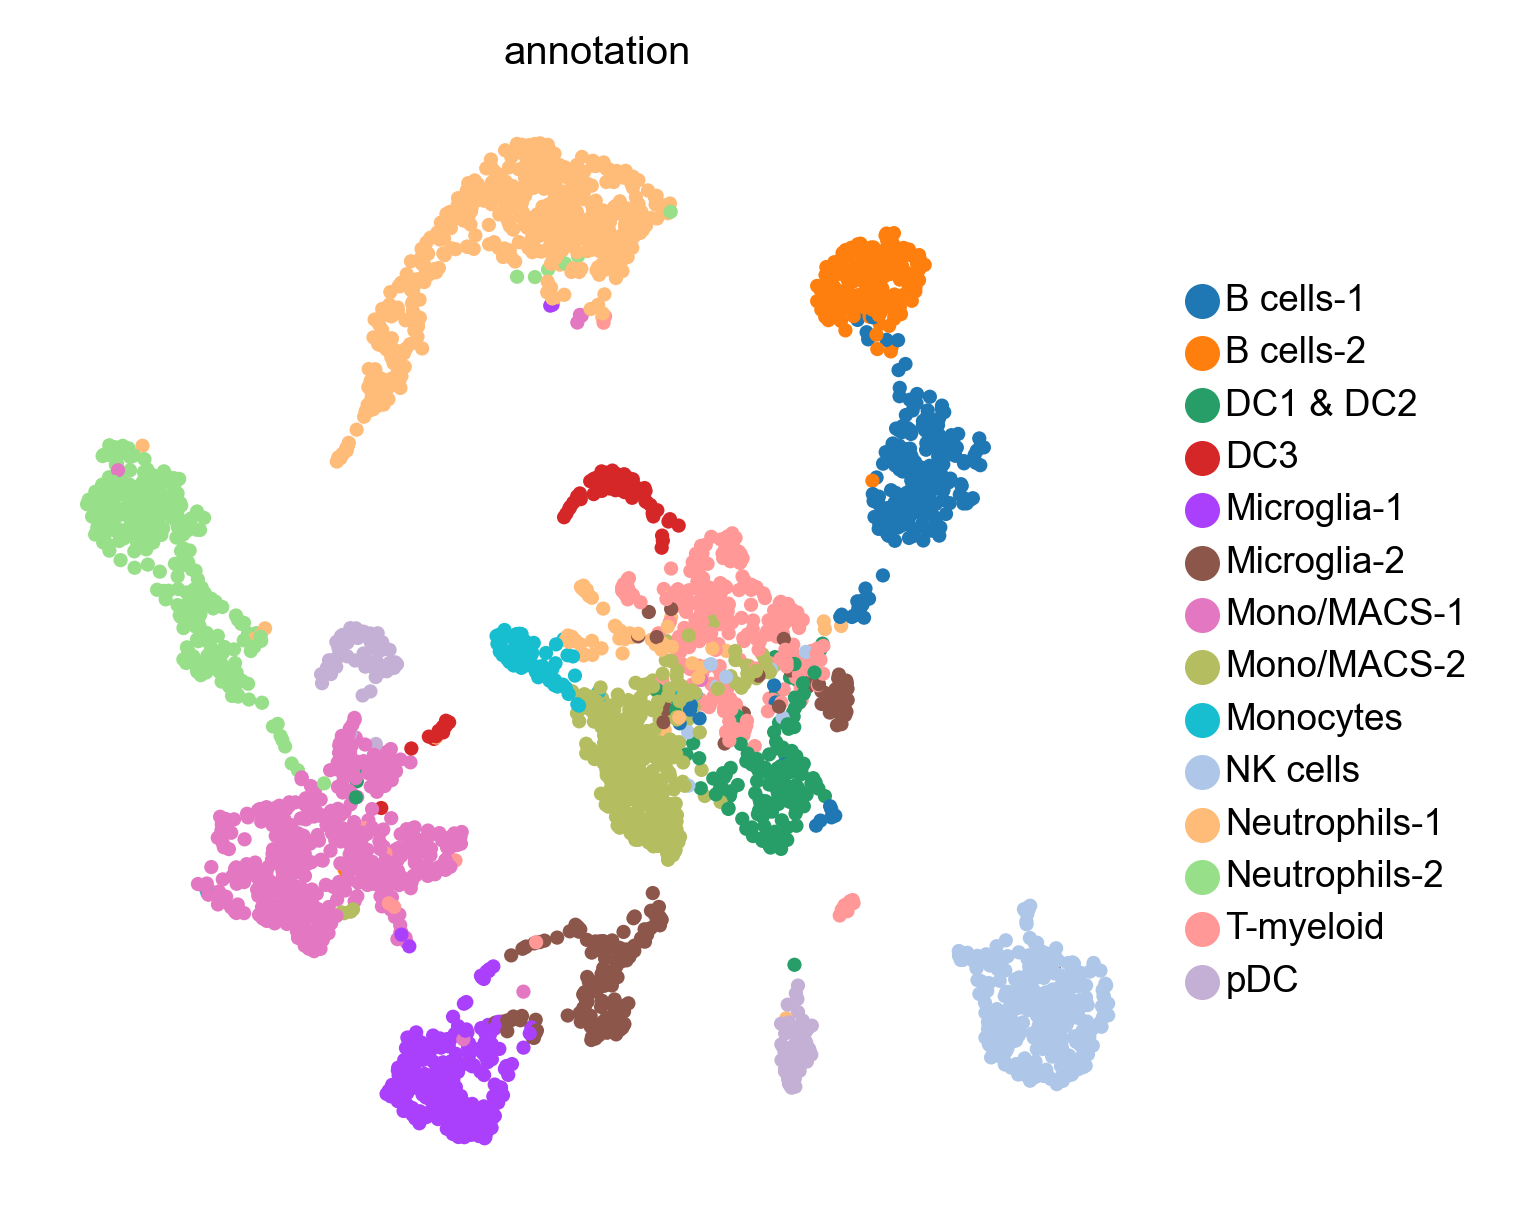

CPU times: total: 42 s
Wall time: 9.79 s


In [255]:
%%time
# Plot the clusters onto UMAP
# Principal component analysis
sc.tl.pca(filtered_adata, svd_solver='arpack')
# Computing the neighborhood graph
sc.pp.neighbors(filtered_adata, n_neighbors=8, n_pcs=20)
# Embed with UMAP
sc.tl.umap(filtered_adata)
# Plot the clusters (it seems that there are some batch effect in this dataset)
sc.pl.umap(filtered_adata, color='annotation')

## select

In [347]:
# Filter the genes by gene type and expression level
filtered_genes = np.array(filtered_raw_adata.var.index)

# Remove the highly expressed genes that may cause over-crowding in MERFISH
percentile_threshold = 99 # remove top 1 percent genes
mask1 = filtered_raw_adata.var['mean_counts'] < np.percentile(filtered_raw_adata.var['mean_counts'], percentile_threshold)
mask2 = filtered_raw_adata.var['max_mean_cluster_count'] < np.percentile(filtered_raw_adata.var['max_mean_cluster_count'], percentile_threshold)
mask = mask1 & mask2
filtered_genes = filtered_genes[mask]

# Remove all mitochondrial genes
mask = [not g.lower().startswith('mt-') for g in filtered_genes]
filtered_genes = filtered_genes[mask]

In [348]:
%%time
# Select the marker genes
adata_filtered = filtered_raw_adata[:, filtered_raw_adata.var.index.isin(filtered_genes)]
# Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell
sc.pp.normalize_total(adata_filtered, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata_filtered)

# Define the marker genes as the differentially expressed genes
sc.tl.rank_genes_groups(adata_filtered, 'annotation', method='wilcoxon')

# Select the top marker genes
N_genes_to_select = 300
marker_genes = set(selected_gene_list)

for i in range(len(adata_filtered.uns['rank_genes_groups']['names'])):
    new_markers = set(adata_filtered.uns['rank_genes_groups']['names'][i])
    for m in new_markers:
        if m not in marker_genes:
            marker_genes.add(m)
            if len(marker_genes) >= N_genes_to_select:
                break
            
    if len(marker_genes) >= N_genes_to_select:
            break

marker_genes = np.array(list(marker_genes))
print(f'Found {len(marker_genes)} marker genes.')

C:\Users\puzheng\.conda\envs\postanalysis\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Found 300 marker genes.
CPU times: total: 7.58 s
Wall time: 7.59 s


In [349]:
selected_genes = marker_genes

In [350]:
# Calculate gene expression levels in the most highly expressed cell types
cluster_labels = np.unique(filtered_raw_adata.obs['annotation'])

gene_max_mean_cluster_counts = np.zeros(filtered_raw_adata.var.shape[0])

for cl in cluster_labels:
    gene_mean_cluster_counts = np.array(np.mean(filtered_raw_adata.X[filtered_raw_adata.obs['annotation'] == cl], axis=0)).flatten()
    gene_max_mean_cluster_counts = np.maximum(gene_max_mean_cluster_counts, gene_mean_cluster_counts)

filtered_raw_adata.var['max_mean_cluster_count'] = gene_max_mean_cluster_counts

C:\Users\puzheng\.conda\envs\postanalysis\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


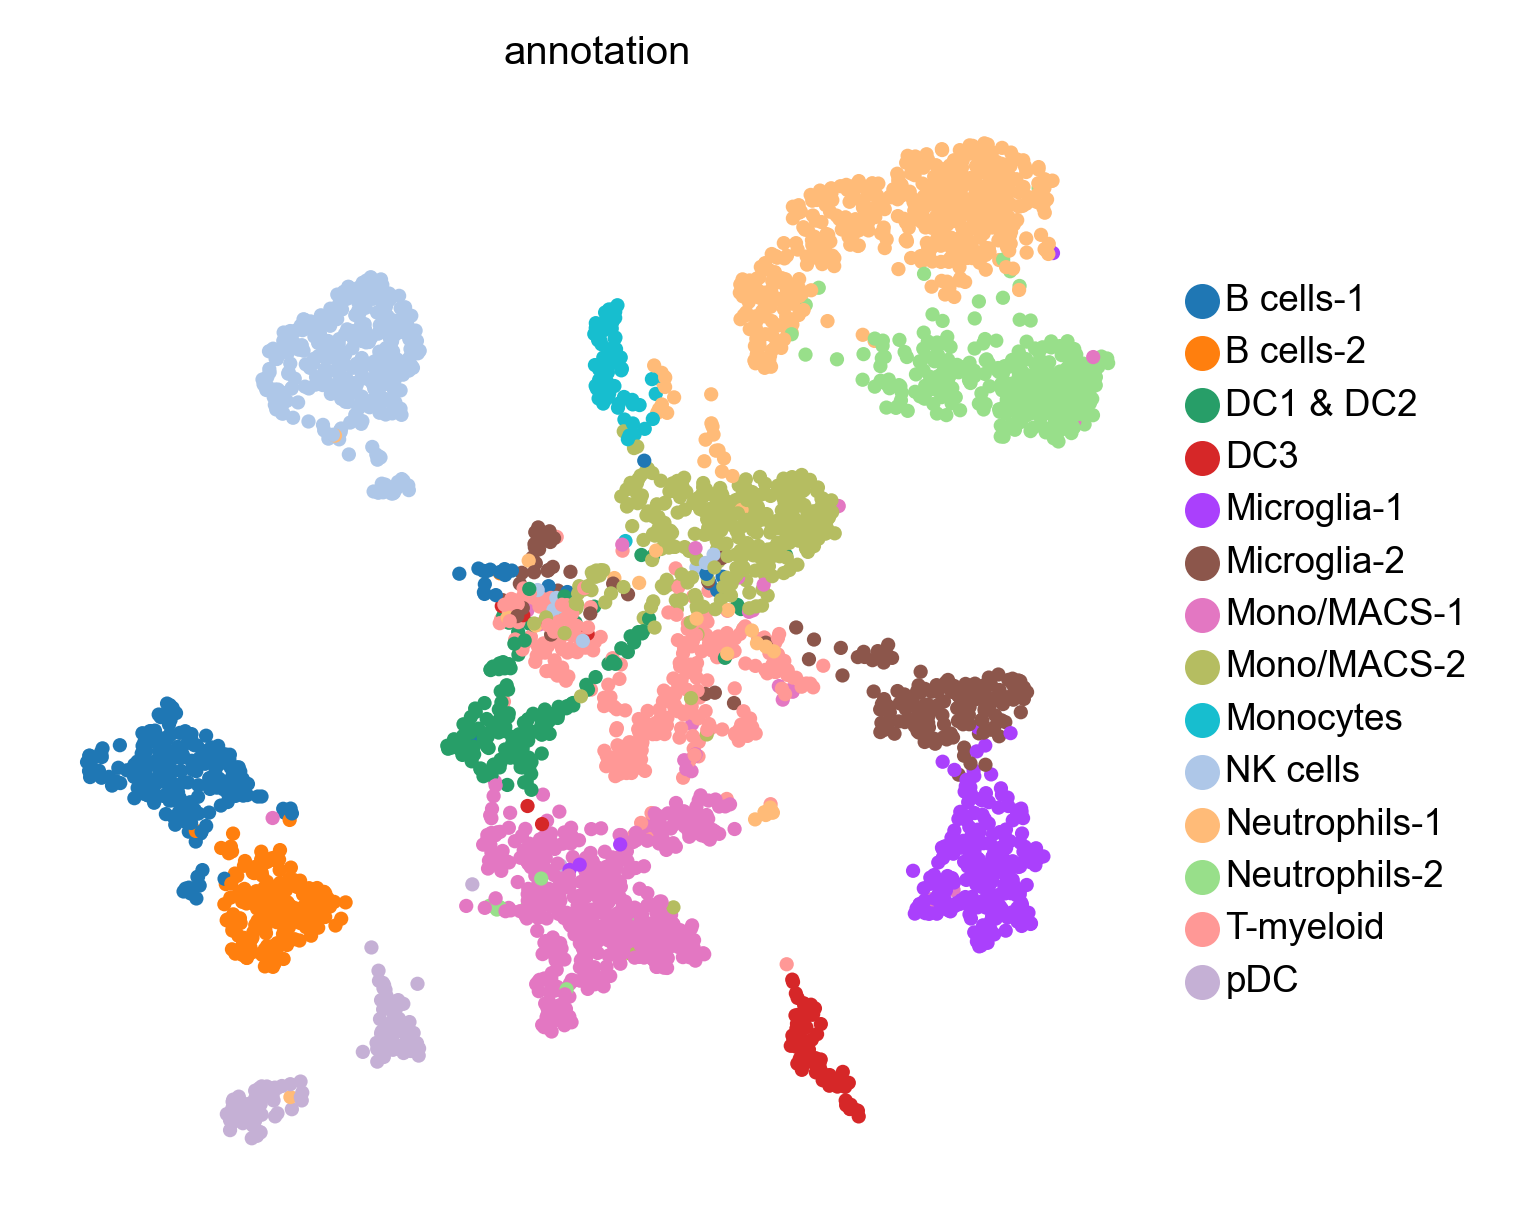

CPU times: total: 10.2 s
Wall time: 5.1 s


In [351]:
%%time
# Validate that the selected genes recapitulate the cluster structures
adata_selected = filtered_adata[:, filtered_adata.var.index.isin(selected_genes)]
# Principal component analysis
sc.tl.pca(adata_selected, svd_solver='arpack')
# Computing the neighborhood graph
sc.pp.neighbors(adata_selected, n_neighbors=5, n_pcs=30)
# Embed with UMAP
sc.tl.umap(adata_selected)
# Plot the clusters
sc.pl.umap(adata_selected, color='annotation')
# Interestingly, the selected genes also removed the batch effect

# Check gene expression in each type

In [370]:
# cell type specific expression
CellTypeMeanExp = pd.DataFrame()
for cell_type in merged_raw_adata.obs.annotation.value_counts().index:
    if cell_type == '':
        continue
    _type_adata = merged_raw_adata[merged_raw_adata.obs['annotation'] == cell_type]
    sc.pp.calculate_qc_metrics(_type_adata, percent_top=None, log1p=False, inplace=True)
    print(cell_type)
    # save mean
    CellTypeMeanExp[cell_type] = _type_adata.var['mean_counts']
    #break


C:\Users\puzheng\.conda\envs\postanalysis\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\puzheng\.conda\envs\postanalysis\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\puzheng\.conda\envs\postanalysis\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\puzheng\.conda\envs\postanalysis\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\puzheng\.conda\envs\postana

Neutrophils-1
Mono/MACS-1
Mono/MACS-2
Neutrophils-2
NK cells
T-myeloid
Microglia-1
B cells-1
B cells-2
Microglia-2
DC1 & DC2
pDC
DC3
Monocytes


C:\Users\puzheng\.conda\envs\postanalysis\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\puzheng\.conda\envs\postanalysis\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\puzheng\.conda\envs\postanalysis\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\puzheng\.conda\envs\postanalysis\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\puzheng\.conda\envs\postana

In [371]:
CellTypeUmiFrac = CellTypeMeanExp.copy()
for cell_type in CellTypeUmiFrac.columns:
    CellTypeUmiFrac[cell_type] = CellTypeUmiFrac[cell_type] / np.sum(CellTypeUmiFrac[cell_type])

## calculate umi fraction of selected genes

In [372]:
CellTypeUmiFrac.columns

Index(['Neutrophils-1', 'Mono/MACS-1', 'Mono/MACS-2', 'Neutrophils-2',
       'NK cells', 'T-myeloid', 'Microglia-1', 'B cells-1', 'B cells-2',
       'Microglia-2', 'DC1 & DC2', 'pDC', 'DC3', 'Monocytes'],
      dtype='object')

In [373]:
CellTypeUmiFrac.loc[selected_genes].values.sum(0)

array([0.24957687, 0.08789214, 0.06189024, 0.10577971, 0.0681489 ,
       0.08540326, 0.08243828, 0.07238998, 0.07877585, 0.08095552,
       0.08000675, 0.06570723, 0.08469443, 0.06830924], dtype=float32)

In [399]:
# remove gene with very high umi
gene_to_remove = []
soft_celltype_th = 2
hard_xs, hard_ys = np.where(CellTypeUmiFrac > 0.008)
soft_xs, soft_ys = np.where(CellTypeUmiFrac > 0.004)

for _ix, _iy in zip(hard_xs, hard_ys):
    _gene = CellTypeUmiFrac.index[_ix]
    _type = CellTypeUmiFrac.columns[_iy]
    if _gene not in gene_to_remove:
        print(f"hard remove: {_gene}")
        gene_to_remove.append(_gene)
print(f"hard remove: {gene_to_remove}")
# soft
for _ix, _iy in zip(soft_xs, soft_ys):
    _gene = CellTypeUmiFrac.index[_ix]
    _type = CellTypeUmiFrac.columns[_iy]
    
    if _gene not in gene_to_remove and np.sum(soft_xs==_ix) >= soft_celltype_th:
        print(f"soft remove: {_gene}")
        gene_to_remove.append(_gene)
print(f"soft remove: {gene_to_remove}")

hard remove: Lcn2
hard remove: Cst3
hard remove: S100a8
hard remove: S100a9
hard remove: Actb
hard remove: Tmsb10
hard remove: Camp
hard remove: Ngp
hard remove: Ltf
hard remove: Lyz2
hard remove: Ccl5
hard remove: Actg1
hard remove: Gzma
hard remove: Retnlg
hard remove: H2-Aa
hard remove: Gm42418
hard remove: Cd74
hard remove: Malat1
hard remove: Fth1
hard remove: Tmsb4x
hard remove: mt-Co1
hard remove: ['Lcn2', 'Cst3', 'S100a8', 'S100a9', 'Actb', 'Tmsb10', 'Camp', 'Ngp', 'Ltf', 'Lyz2', 'Ccl5', 'Actg1', 'Gzma', 'Retnlg', 'H2-Aa', 'Gm42418', 'Cd74', 'Malat1', 'Fth1', 'Tmsb4x', 'mt-Co1']
soft remove: B2m
soft remove: Il1b
soft remove: Rps8
soft remove: Rps9
soft remove: Ftl1
soft remove: Ifitm3
soft remove: Rpl13
soft remove: Eef1a1
soft remove: Rpsa
soft remove: Psap
soft remove: H3f3b
soft remove: Rps24
soft remove: Tpt1
soft remove: H2-Ab1
soft remove: H2-Eb1
soft remove: H2-D1
soft remove: Gm26917
soft remove: Fau
soft remove: mt-Co2
soft remove: mt-Atp6
soft remove: mt-Co3
soft rem

In [402]:
kept_selected_genes = np.array([_g for _g in selected_genes if _g not in gene_to_remove])

In [403]:
np.sum(CellTypeUmiFrac.loc[kept_selected_genes], axis=0)

Neutrophils-1    0.050185
Mono/MACS-1      0.074283
Mono/MACS-2      0.055155
Neutrophils-2    0.084465
NK cells         0.049770
T-myeloid        0.057225
Microglia-1      0.073867
B cells-1        0.050217
B cells-2        0.061685
Microglia-2      0.064742
DC1 & DC2        0.047355
pDC              0.057519
DC3              0.059810
Monocytes        0.058094
dtype: float32

In [404]:
len(kept_selected_genes)

294

In [405]:
CellTypeMeanExp

,Neutrophils-1,Mono/MACS-1,Mono/MACS-2,Neutrophils-2,NK cells,T-myeloid,Microglia-1,B cells-1,B cells-2,Microglia-2,DC1 & DC2,pDC,DC3,Monocytes
gene_symbols,,,,,,,,,,,,,,
Xkr4,0.000000,0.000000,0.000000,0.00000,0.003096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Gm1992,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Gm19938,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Gm37381,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Rp1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC124606.1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC133095.2,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC133095.1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# save taget genes

In [415]:
target_gene_mean_exp_df = CellTypeMeanExp.loc[kept_selected_genes]
target_gene_mean_exp_filename = os.path.join(library_folder, 'selected_gene_mean_exp.csv')
# save
print(f"saving mean_exp for target genes: {target_gene_mean_exp_filename}")
target_gene_mean_exp_df.to_csv(target_gene_mean_exp_filename)

saving mean_exp for target genes: \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\Brain_MS_immune\selected_gene_mean_exp.csv


In [416]:
target_gene_umi_frac_df = CellTypeUmiFrac.loc[kept_selected_genes]
target_gene_umi_frac_filename = os.path.join(library_folder, 'selected_gene_umi_frac.csv')
# save
print(f"saving umi_frac for target genes: {target_gene_umi_frac_filename}")
target_gene_umi_frac_df.to_csv(target_gene_umi_frac_filename)

saving umi_frac for target genes: \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\Brain_MS_immune\selected_gene_umi_frac.csv


In [421]:
celltype_num = filtered_raw_adata.obs.annotation.value_counts()

celltype_num_filename = os.path.join(library_folder, 'celltype_num.csv')
celltype_num.to_csv(celltype_num_filename)